## Inicialización

In [35]:
from PIL import Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Input

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf


## Cargar datos

El conjunto de datos se almacena en la carpeta `/datasets/faces/`
- La carpeta `final_files` con 7600 fotos
- El archivo `labels.csv` con leyendas, con dos columnas: `file_name` y `real_age`

Dado que el número de archivos de imágenes es bastante elevado, se recomienda evitar leerlos todos a la vez, ya que esto consumiría muchos recursos computacionales. Te recomendamos crear un generador con ImageDataGenerator. Este método se explicó en el capítulo 3, lección 7 de este curso.

El archivo de etiqueta se puede cargar como un archivo CSV habitual.

In [36]:
'''RUTA DE IMAGENES'''
path='/datasets/faces/final_files/'
files= os.listdir(path)
print(f'La ruta "{path}" tiene {len(files)} archivos')


La ruta "/datasets/faces/final_files/" tiene 7591 archivos


Se corrobora que tenemos 7,591 frente a los 7,600 anteriormente mencionados. Es decir 9 imagenes menos. Esto no representará un problema para el proyecto pero se estipulara como comentario.

## EDA

In [37]:
labels_df = pd.read_csv('/datasets/faces/labels.csv')

labels_df.sample(10)

,file_name,real_age
1806,001806.jpg,19
4281,004281.jpg,25
5197,005197.jpg,37
5363,005363.jpg,45
6326,006330.jpg,18
2370,002370.jpg,25
3524,003524.jpg,23
3395,003395.jpg,19
3173,003173.jpg,15
4204,004204.jpg,22


In [38]:
labels_df.describe()

,real_age
count,7591.000000
mean,31.201159
std,17.145060
min,1.000000
25%,20.000000
50%,29.000000
75%,41.000000
max,100.000000


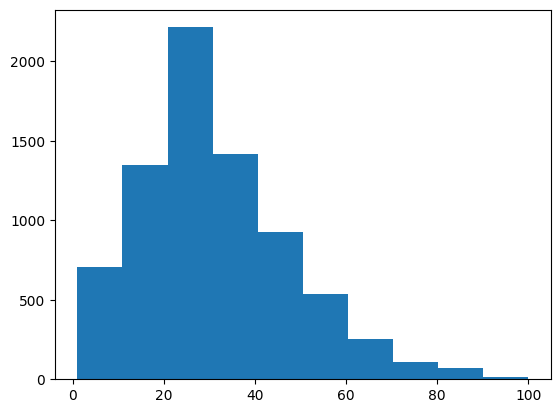

In [39]:
plt.hist(labels_df['real_age'])
plt.show()

Como podemos obvservar, las concentraciones de las edades en este directorio de imagenes se encuentran mayormente entre los 20's y los 40's siendo el grupo de los 30's el que presenta mayor frecuencia

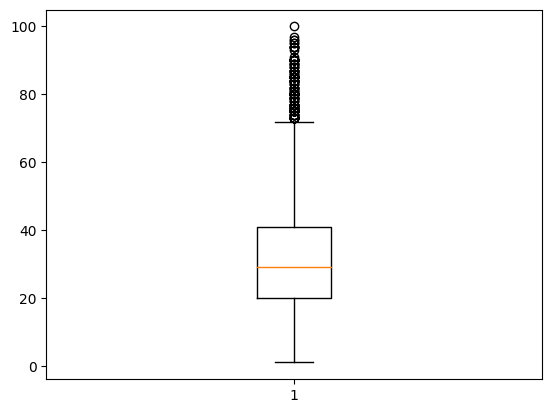

In [40]:
plt.boxplot(labels_df['real_age'])
plt.show()

En este boxplot podemos confirmar lo antes mencionado, nuestra media se encuentra en el rango de los 30's. También, podemos observar que los rangos de los bigotes se encuentran entre 1 y los 70, siendo las edades superiores, valores átipicos pero presentes en nuestros resultados (como por ejemplo la persona con una edad de 100).

### Conclusiones

Los datos estan limpios y estables, la distribución de edades concuerda respecto a la distribución por edad en el mundo (src='https://www.indexmundi.com/es/mundo/distribucion_por_edad.html'). El modelado de datos con CNN podrá darnos buenos resultados.

## Modelado

Define las funciones necesarias para entrenar tu modelo en la plataforma GPU y crear un solo script que las contenga todas junto con la sección de inicialización.

Para facilitar esta tarea, puedes definirlas en este notebook y ejecutar un código listo en la siguiente sección para componer automáticamente el script.

Los revisores del proyecto también verificarán las definiciones a continuación, para que puedan comprender cómo construiste el modelo.

In [22]:
 datagen = ImageDataGenerator(validation_split=0.25, rescale=1/255.)

In [23]:
def load_train(path):
    """
    Carga de entrenamiento del conjunto de datos desde la ruta
    """
    
    train_gen_flow = datagen.flow_from_dataframe(
        dataframe= pd.read_csv('D:/Tripleten/datasets/faces/labels.csv'),
        directory= path, 
        x_col='file_name',
        y_col='real_age',
        target_size=(150,150), # La imagen mas pequeña es de 47,47
        batch_size=16,
        class_mode='raw',
        seed=12345,
        subset='training'
    )

    return train_gen_flow

In [25]:
def load_test(path):
    
    """
    Carga de validación/prueba del conjunto de datos desde la ruta
    """
    test_gen_flow = datagen.flow_from_dataframe(
        dataframe= pd.read_csv('D:/Tripleten/datasets/faces/labels.csv'),
        directory= path, 
        x_col='file_name',
        y_col='real_age',
        target_size=(150,150), # La imagen mas pequeña es de 47,47
        batch_size=16,
        class_mode='raw',
        seed=12345,
        subset='validation'
    )
    return test_gen_flow

In [30]:
def create_model(input_shape):
    
    """Definiendo el modelo"""
    
    base_model = Resnet50(
        weights='imagenet',
        include_top=False,
        input_shape=input_shape)
    
    base_model.trainable=False
    
    model = Sequential(
        [
        base_model,
        GlobalAveragePooling2D(),
        Dense(1, activation='relu'), ### Preguntar esta parte
        ]
    )
    model.compile(optimizer=Adam(learning_rate= 0.0001),loss='mean_squared_error', metrics=['mae'])

    return model

In [33]:
def train_model(model, train_data, test_data, batch_size=None, epochs=20,
                steps_per_epoch=None, validation_steps=None):

    """
    Entrena el modelo dados los parámetros
    """
    
    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)

    
    model.fit(
        train_data,
        validation_data=test_data,
        batch_size=batch_size,
        epochs=epochs,
        steps_per_epoch=steps_per_epoch,
        validation_steps=validation_steps
             )
    
    return model

### Prepara el script para ejecutarlo en la plataforma GPU

Una vez que hayas definido las funciones necesarias, puedes redactar un script para la plataforma GPU, descargarlo a través del menú "File|Open..." (Archivo|Abrir) y cargarlo más tarde para ejecutarlo en la plataforma GPU.

Nota: el script debe incluir también la sección de inicialización. A continuación se muestra un ejemplo.

In [34]:
# prepara un script para ejecutarlo en la plataforma GPU

init_str = """
import pandas as pd
import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam
"""

import inspect

with open('run_model_on_gpu.py', 'w') as f:
    
    f.write(init_str)
    f.write('\n\n')
        
    for fn_name in [load_train, load_test, create_model, train_model]:
        
        src = inspect.getsource(fn_name)
        f.write(src)
        f.write('\n\n')

### Resultado

Coloca aquí el resultado de la plataforma GPU como una celda Markdown.

Train for 356 steps, validate for 119 steps
Epoch 1/23
2024-05-28 21:27:38.082060: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2024-05-28 21:27:38.313882: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
356/356 - 47s - loss: 223.6400 - mae: 11.4360 - val_loss: 309.1223 - val_mae: 13.0490
Epoch 2/23
356/356 - 38s - loss: 148.4378 - mae: 9.3597 - val_loss: 298.4119 - val_mae: 12.8272
Epoch 3/23
356/356 - 38s - loss: 128.0000 - mae: 8.6467 - val_loss: 215.8631 - val_mae: 10.7793
Epoch 4/23
356/356 - 38s - loss: 109.0916 - mae: 8.0215 - val_loss: 190.0480 - val_mae: 11.2995
Epoch 5/23
356/356 - 38s - loss: 93.0879 - mae: 7.3888 - val_loss: 136.6849 - val_mae: 8.7553
Epoch 6/23
356/356 - 38s - loss: 79.8182 - mae: 6.8526 - val_loss: 158.6466 - val_mae: 9.5397
Epoch 7/23
356/356 - 38s - loss: 68.0044 - mae: 6.3503 - val_loss: 125.1458 - val_mae: 8.5112
Epoch 8/23
356/356 - 38s - loss: 62.0038 - mae: 6.0753 - val_loss: 104.7177 - val_mae: 7.7440
Epoch 9/23
356/356 - 38s - loss: 51.6462 - mae: 5.5800 - val_loss: 109.3861 - val_mae: 8.0175
Epoch 10/23
356/356 - 40s - loss: 47.6364 - mae: 5.3328 - val_loss: 92.1688 - val_mae: 7.3101
Epoch 11/23
356/356 - 38s - loss: 40.9385 - mae: 4.8812 - val_loss: 223.6011 - val_mae: 12.1987
Epoch 12/23
356/356 - 38s - loss: 34.8084 - mae: 4.5803 - val_loss: 116.4056 - val_mae: 8.0484
Epoch 13/23
356/356 - 38s - loss: 28.1013 - mae: 4.0827 - val_loss: 91.1830 - val_mae: 7.2154
Epoch 14/23
356/356 - 38s - loss: 27.2839 - mae: 4.0450 - val_loss: 103.8520 - val_mae: 7.6005
Epoch 15/23
356/356 - 38s - loss: 28.1634 - mae: 4.0645 - val_loss: 120.8307 - val_mae: 8.4843
Epoch 16/23
356/356 - 38s - loss: 26.3836 - mae: 3.9835 - val_loss: 90.7478 - val_mae: 7.0941
Epoch 17/23
356/356 - 38s - loss: 21.9634 - mae: 3.6271 - val_loss: 90.5392 - val_mae: 7.2509
Epoch 18/23
356/356 - 38s - loss: 20.6232 - mae: 3.5156 - val_loss: 84.3007 - val_mae: 6.8676
Epoch 19/23
356/356 - 38s - loss: 19.3186 - mae: 3.4002 - val_loss: 87.6615 - val_mae: 7.0264
Epoch 20/23
356/356 - 38s - loss: 17.6347 - mae: 3.2226 - val_loss: 90.1937 - val_mae: 7.1047
Epoch 21/23
356/356 - 38s - loss: 17.2872 - mae: 3.1997 - val_loss: 89.0919 - val_mae: 7.2848
Epoch 22/23
356/356 - 38s - loss: 17.9529 - mae: 3.2405 - val_loss: 94.6801 - val_mae: 7.3355
Epoch 23/23
356/356 - 38s - loss: 18.6326 - mae: 3.3411 - val_loss: 89.4653 - val_mae: 7.2161
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
119/119 - 9s - loss: 89.4653 - mae: 7.2161
Test MAE: 7.2161

## Conclusiones

Durante la carga de los datos, se corroboró que tenemos 7,591 frente a los 7,600 anteriormente mencionados, esto no representa una afectación grave al entrenamiento de los modelos. También se analizó la coherencia de los datos de acuerdo con la distribución de los datos para el entrenamiento.

Durante las primeras epocas del entrenamiento, los resultados de perdida eran mayores a 100 mse para los valores de entrenamiento y 160 para los valores de validación, sin embargo con el avance de las epocas se logró reducir los valores hasta obtener una perdida de 18.63 y un error medio absoluto de 3.34 para el conjunto de entrenamiento, mientras que para el conjunto de validación obtuvimos 89.4 de perdidad y un error medio absoluto de 7.2.

Los resultados son satisfactorio de acuerdo al umbral establecido por superar de 8

# Lista de revisión

- [x]  El Notebook estaba abierto 
- [x]  El código no tiene errores
- [x]  Las celdas con el código han sido colocadas en el orden de ejecución
- [x]  Se realizó el análisis exploratorio de datos
- [x]  Los resultados del análisis exploratorio de datos se presentan en el notebook final
- [x]  El valor EAM del modelo no es superior a 8
- [x]  El código de entrenamiento del modelo se copió en el notebook final
- [x]  El resultado de entrenamiento del modelo se copió en el notebook final
- [x]  Los hallazgos se proporcionaron con base en los resultados del entrenamiento del modelo